In [1]:
!pip install pysoundfile

In [0]:
!rm -rf RAVDESS/
!rm -rf RAVDESS/train_valid     # use this to clean the Data Set folder
#!rm -rf RAVDESS.zip  # use this to force re download


In [0]:
# helper to download the Data Set from Google Drive

import requests
import os

def download_file_from_google_drive(id, destination):
    URL = "https://docs.google.com/uc?export=download"

    session = requests.Session()

    response = session.get(URL, params = { 'id' : id }, stream = True)
    token = get_confirm_token(response)

    if token:
        params = { 'id' : id, 'confirm' : token }
        response = session.get(URL, params = params, stream = True)

    save_response_content(response, destination)    

def get_confirm_token(response):
    for key, value in response.cookies.items():
        if key.startswith('download_warning'):
            return value

    return None

def save_response_content(response, destination):
    CHUNK_SIZE = 32768

    with open(destination, "wb") as f:
        for chunk in response.iter_content(CHUNK_SIZE):
            if chunk: # filter out keep-alive new chunks
                f.write(chunk)


# Download the Data Set

Uncomment the `file_id` of the Data Set you want to use.




In [0]:
# RAVDESS_original.zip https://drive.google.com/open?id=1WyJsDuxJlUObBCFrNZLAXM2w4-sp0CxN
# file_id = '1WyJsDuxJlUObBCFrNZLAXM2w4-sp0CxN'

# RAVDESS_trimmed.zip https://drive.google.com/open?id=1pFum_YGf2C82HJvMwt0gi8apj6PJLi0s
# file_id = '1pFum_YGf2C82HJvMwt0gi8apj6PJLi0s'

file_id ='1pFum_YGf2C82HJvMwt0gi8apj6PJLi0s'

destination = 'RAVDESS.zip'

if not os.path.exists(destination):
    download_file_from_google_drive(file_id, destination)

In [5]:
!ls -l

total 437256
-rw-r--r-- 1 root root 447739985 Dec 13 22:51 RAVDESS.zip
drwxr-xr-x 1 root root      4096 Dec 12 16:48 sample_data


In [6]:
!unzip -n RAVDESS.zip

Archive:  RAVDESS.zip
   creating: RAVDESS/
   creating: RAVDESS/enriched/
   creating: RAVDESS/trimmed/
  inflating: RAVDESS/trimmed/03-01-07-02-01-01-23.wav  
  inflating: RAVDESS/trimmed/03-01-08-02-01-02-01.wav  
  inflating: RAVDESS/trimmed/03-01-03-02-02-02-16.wav  
  inflating: RAVDESS/trimmed/03-01-02-02-02-02-17.wav  
  inflating: RAVDESS/trimmed/03-01-06-01-02-02-22.wav  
  inflating: RAVDESS/trimmed/03-01-08-02-01-01-20.wav  
  inflating: RAVDESS/trimmed/03-01-07-02-02-02-17.wav  
  inflating: RAVDESS/trimmed/03-01-05-02-01-02-20.wav  
  inflating: RAVDESS/trimmed/03-01-06-02-02-01-03.wav  
  inflating: RAVDESS/trimmed/03-01-07-01-01-02-14.wav  
  inflating: RAVDESS/trimmed/03-01-07-02-01-01-24.wav  
  inflating: RAVDESS/trimmed/03-01-08-02-01-01-13.wav  
  inflating: RAVDESS/trimmed/03-01-07-01-02-01-04.wav  
  inflating: RAVDESS/trimmed/03-01-03-02-01-02-09.wav  
  inflating: RAVDESS/trimmed/03-01-06-02-01-01-17.wav  
  inflating: RAVDESS/trimmed/03-01-03-02-01-02-12.wav  

In [7]:
!ls RAVDESS/ -l

total 144
drwxr-xr-x 2 root root  4096 Oct 15 19:44 enriched
drwxr-xr-x 2 root root 69632 Oct 15 20:43 original
drwxr-xr-x 2 root root  4096 Oct 15 19:44 spectograms
drwxr-xr-x 2 root root 69632 Oct 15 19:50 trimmed


In [8]:
!echo "Files in RAVDESS/original:" $(find RAVDESS/original/ -type f| wc -l)
!echo "Files in RAVDESS/trimmed:" $(find RAVDESS/trimmed/ -type f| wc -l)
!echo "Files in RAVDESS/enriched:" $(find RAVDESS/enriched/ -type f| wc -l)
!echo "Files in RAVDESS/mfcc:" $(find RAVDESS/mfcc/ -type f| wc -l)

Files in RAVDESS/original: 1440
Files in RAVDESS/trimmed: 1440
Files in RAVDESS/enriched: 0
find: ‘RAVDESS/mfcc/’: No such file or directory
Files in RAVDESS/mfcc: 0


In [0]:
import numpy as np
import pandas as pd
import soundfile as sf
import librosa
import librosa.display
from scipy.signal import spectrogram
import math
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import pylab
import random
import re
import gc
from IPython.display import Image, display
import sklearn
from sklearn.model_selection import train_test_split
from PIL import Image, ImageFile
ImageFile.LOAD_TRUNCATED_IMAGES = True
from shutil import copyfile

In [0]:
random.seed(42) # set the random seed

In [0]:
# This class handles the preparation of the RAVDESS Data Set

class RAVDESS:
    
    def __init__(self, frequency):
        # store audio file name identifier mapping helpers, see the original documentation https://zenodo.org/record/1188976#.XaYUupIzaUk
        self.frequency = frequency
        self.separator = "-"
        self.audio_only = "03"
        self.voice_channel = "01"
        self.emotions = {
            "01": "neutral", 
            "02": "calm", 
            "03": "happy", 
            "04": "sad", 
            "05": "angry", 
            "06": "fearful", 
            "07": "disgust", 
            "08": "surprised"
        }
        self.emotion_intensities = {"01": "normal", "02": "strong"}
        self.statements = {"01": "Kids_are_talking_by_the_door", "02": "Dogs_are_sitting_by_the_door"}
        self.repetitions = ["01", "02"]
        self.actors = {
            "01": "male", 
            "02": "female", 
            "03": "male", 
            "04": "female", 
            "05": "male", 
            "06": "female", 
            "07": "male", 
            "08": "female", 
            "09": "male", 
            "10": "female", 
            "11": "male", 
            "12": "female", 
            "13": "male", 
            "14": "female", 
            "15": "male", 
            "16": "female", 
            "17": "male", 
            "18": "female", 
            "19": "male", 
            "20": "female", 
            "21": "male", 
            "22": "female", 
            "23": "male",
            "24": "male",
        }
        self.shown_specs = 0

        # store helper paths
        self.data_set_path = 'RAVDESS/'
        self.original_data_path = self.data_set_path + 'original/'
        self.trimmed_data_path = self.data_set_path + 'trimmed/'
        self.enriched_data_path = self.data_set_path + 'enriched/'
        self.mfcc_data_path = self.data_set_path + 'mfcc/'
        self.spectograms_data_path = self.data_set_path + 'spectograms/'
        self.split_image_data_path = self.data_set_path + 'split_image/'
        self.train_valid_path = self.data_set_path + 'train_valid/'
        self.train_path = self.train_valid_path + 'train/'
        self.valid_path = self.train_valid_path + 'valid/'

        # create the directories if needed
        if not os.path.exists(self.trimmed_data_path):
          os.mkdir(self.trimmed_data_path)

        if not os.path.exists(self.enriched_data_path):
          os.mkdir(self.enriched_data_path)

        if not os.path.exists(self.mfcc_data_path):
          os.mkdir(self.mfcc_data_path)

        if not os.path.exists(self.spectograms_data_path):
          os.mkdir(self.spectograms_data_path)

        if not os.path.exists(self.split_image_data_path):
          os.mkdir(self.split_image_data_path)

        if not os.path.exists(self.train_valid_path):
          os.mkdir(self.train_valid_path)
          os.mkdir(self.train_path)
          os.mkdir(self.valid_path)

        return

    # List all audio file paths
    def get_audio_paths_common(self, directory):
        audio_files = os.listdir(directory) # list all audio files
        audio_files = [directory + audio_file_name for audio_file_name in audio_files] # append prefix path
        return audio_files

    def get_original_audio_paths(self):
        return self.get_audio_paths_common(self.original_data_path)

    def get_trimmed_audio_paths(self):
        return self.get_audio_paths_common(self.trimmed_data_path)

    def get_mfcc_paths(self):
        return self.get_audio_paths_common(self.mfcc_data_path)

    def get_enriched_audio_paths(self):
        return self.get_audio_paths_common(self.enriched_data_path)
    
    def get_spectograms_paths(self):
        return self.get_audio_paths_common(self.spectograms_data_path)
    
    def get_split_image_paths(self):
        return self.get_audio_paths_common(self.split_image_data_path)

    def get_file_name_without_extension(self, file_path):
        return os.path.splitext(os.path.basename(file_path))[0]

    
    # Trim the silent data from the audio files
    def trim_audios(self):
        print('Trimming audio files - remove the silent data from the audio files')
        num_of_original_files = len(os.listdir(self.original_data_path))
        num_of_trimmed_files = len(os.listdir(self.trimmed_data_path))
        print(str(num_of_trimmed_files) + '/' + str(num_of_original_files))

        audio_paths = self.get_original_audio_paths()
        finished = 0
        for audio_path in audio_paths:
            new_trimmed_file_path = self.trimmed_data_path + os.path.basename(audio_path) # on a new path with the same file name

            # if the trimmed file doesn't exist create it
            if not os.path.exists(new_trimmed_file_path):
                audio_data, samplerate = librosa.load(audio_path, sr=self.frequency) # load and convert the audio
                audio_data_filtered, index = librosa.effects.trim(audio_data, top_db=30, frame_length=2048, hop_length=512) # trim the silent data from the audio file

                librosa.output.write_wav(new_trimmed_file_path, audio_data_filtered, samplerate) # write out the trimmed data

                finished += 1
                print(str(num_of_trimmed_files + finished) + '/' + str(num_of_original_files) + ' Trimmed: ' + audio_path) # log progress
    
    def create_mfcc(self, show_first_n):
        print('Creating MFCC for audio files')
        num_of_enriched_files = len(os.listdir(self.enriched_data_path))
        num_of_mfcc_files = len(os.listdir(self.mfcc_data_path))
        print(str(num_of_mfcc_files) + '/' + str(num_of_enriched_files))

        shown_n = 0
        finished = 0
        audio_paths = self.get_enriched_audio_paths()
        for audio_path in audio_paths:
          new_mfcc_file_path = self.mfcc_data_path + self.get_file_name_without_extension(audio_path) + '.nparray' #  set directory and remove file extension from the trimmed path

          if not os.path.exists(new_mfcc_file_path):
          
            audio_data, samplerate = librosa.load(audio_path, sr=self.frequency)
            mfccs = librosa.feature.mfcc(y=audio_data, sr=samplerate, n_mfcc=13)
            mfccs = sklearn.preprocessing.scale(mfccs, axis=1) # scale the data
            np.savetxt(new_mfcc_file_path, mfccs, delimiter=',')
            
            if shown_n < show_first_n:
              print('Shape: '+ str(mfccs.shape)) # 20
              librosa.display.specshow(mfccs, sr=samplerate, x_axis='time')
              plt.show()
              shown_n += 1

            finished += 1
            print(str(num_of_mfcc_files + finished) + '/' + str(num_of_enriched_files) + ' MFCC created: ' + new_mfcc_file_path) # log progress        


    # Add noise to the audio to create more samples
    def create_audio_with_noise(self, data, number_of_noisy_audios):
        mean, std = data.mean(), data.std()
        noised_data = []

        # Add noise based on the standard deviation
        for i in range(number_of_noisy_audios):
            noise = np.random.normal(mean, std*random.uniform(0.005, 0.07), data.shape) 
            noised_data.append(data + noise)
        return noised_data

    # Save the noised audio data
    def create_save_noised_audio(self, number_of_noisy_audios):
        print('Noise audios - enrich the original ' + str(number_of_noisy_audios + 1) + ' times')
        num_of_trimmed_files = len(os.listdir(self.trimmed_data_path))
        num_of_needed_enriched_files = num_of_trimmed_files * (number_of_noisy_audios + 1)
        num_of_enriched_files = len(os.listdir(self.enriched_data_path))
        print(str(num_of_enriched_files) + '/' + str(num_of_needed_enriched_files))

        audio_paths = self.get_trimmed_audio_paths()
        finished = 0
        for audio_path in audio_paths:
            audio_data, samplerate = sf.read(audio_path) # load the audio

            new_path_base = self.enriched_data_path + self.get_file_name_without_extension(audio_path) # set directory and remove file extension from the original path
            unmodified_data_new_path = new_path_base + '-00.wav' # append a new identifier Noised data ID
            if not os.path.exists(unmodified_data_new_path):
                sf.write(unmodified_data_new_path, audio_data, samplerate) # this is the non noised trimmed audio
                finished += 1
                print(str(num_of_enriched_files + finished) + '/' + str(num_of_needed_enriched_files) + ' Enrichment: ' + unmodified_data_new_path) # log progress

            # add noise to the trimmed audio
            noised_data = self.create_audio_with_noise(audio_data, number_of_noisy_audios)

            # write out the noised audio
            for i in range(0, len(noised_data)):
                new_file_name = new_path_base + '-' + "{:02d}".format(i+1) + '.wav'
                if not os.path.exists(new_file_name):
                    sf.write(new_file_name, noised_data[i], samplerate)

                    finished += 1
                    print(str(num_of_enriched_files + finished) + '/' + str(num_of_needed_enriched_files) + ' Enrichment: ' + new_file_name) # log progress
                    
                      
    def create_spectograms(self):
        print('Create spectograms')
        num_of_enriched_files = len(os.listdir(self.enriched_data_path))
        num_of_spectograms = len(os.listdir(self.spectograms_data_path))
        print(str(num_of_spectograms) + '/' + str(num_of_enriched_files))

        audio_paths = self.get_enriched_audio_paths()
        finished = 0
        for audio_path in audio_paths:
            spectogram_path = self.spectograms_data_path + self.get_file_name_without_extension(audio_path) + '.png' # create a path with the same name and a replaced file extension
            if not os.path.exists(spectogram_path):
                audio_data, samplerate = sf.read(audio_path)
                nfft = 256
                fig,ax = plt.subplots(1)
                fig.subplots_adjust(left=0,right=1,bottom=0,top=1)
                fig.set_size_inches(8*len(audio_data)/samplerate,8)
                spect, f, t, image = plt.specgram(audio_data, NFFT=nfft, Fs=samplerate, noverlap=nfft/2, cmap=pylab.get_cmap('Greys'))
                plt.axis('off')
                fig.savefig(spectogram_path, dpi=300)

                finished += 1
                print(str(num_of_spectograms + finished) + '/' + str(num_of_enriched_files) + ' Created spectogram: ' + spectogram_path) # log progress

                plt.close()
                gc.collect() # this won't solve the issue, but it will crash later... https://github.com/matplotlib/matplotlib/issues/8519


    def split_image_data(self, width = 500):
        print('Split image data')
        num_of_spectograms = len(os.listdir(self.spectograms_data_path))
        ls = os.listdir(ravdess.split_image_data_path)
        num_of_splitted_images = len(set([i[:i.rfind('-')] for i in ls]))
        print(str(num_of_splitted_images) + '/' + str(num_of_spectograms))

        spectogram_paths = self.get_spectograms_paths()
        finished = 0
        for spectogram_path in spectogram_paths:
            split_image_path = self.split_image_data_path + self.get_file_name_without_extension(spectogram_path) + '-0.png'
            if not os.path.exists(split_image_path):
                im = Image.open(spectogram_path)
                imgwidth, imgheight = im.size
                split_image_path = self.split_image_data_path + self.get_file_name_without_extension(spectogram_path) + '-'
                for j in range(0,imgwidth,width):
                    if j + width > imgwidth:
                        j = imgwidth - width
                    box = (j, 0, j+width, imgheight)
                    a = im.crop(box)
                    a.save(split_image_path + str(j) + '.png')
                
                finished += 1
                print(str(num_of_splitted_images + finished) + '/' + str(num_of_spectograms) + ' Create split image from: ' + split_image_path )
                
                    
    
    def name_to_data(self, path):
        numbers = re.findall(r'\d+', path) # numbers in the name of the audio file
        return [
            self.emotions[numbers[2]],
            self.emotion_intensities[numbers[3]],
            self.statements[numbers[4]],
            self.repetitions[int(numbers[5])-1],
            numbers[6], 
            self.actors[numbers[6]],
            path,
            self.get_file_name_without_extension(path)[:-3],
            numbers[7]
        ]

    # Creates the Data Frame for the RAVDESS
    def create_dataframe_mfcc(self):
        print('Create MFCC dataframe')
        data = []
        mfcc_paths = self.get_mfcc_paths()
        for mfcc_path in mfcc_paths:
            data.append(self.name_to_data(mfcc_path))

        df = pd.DataFrame(  # contruct DataFrame from data
            { 
                'emotion'           : pd.Categorical([row[0] for row in data]),
                'emotion_intensity' : pd.Categorical([row[1] for row in data]),
                'statement'         : pd.Categorical([row[2] for row in data]),
                'repetition'        : pd.Categorical([row[3] for row in data]),
                'actor'             : pd.Categorical([row[4] for row in data]),
                'actor_gender'      : pd.Categorical([row[5] for row in data]),
                'mfcc_path'         : pd.Categorical([row[6] for row in data]),
                'original_data_id'  : pd.Categorical([row[7] for row in data]),
                'enrichment_num'    : pd.Categorical([row[8] for row in data])
            })
        
        return df

    def create_train_structure(self, df):
        emotion = df['emotion'].unique()
        for i in emotion: 
            if not os.path.exists(self.train_path + i):
                os.mkdir(self.train_path + i)
                os.mkdir(self.valid_path + i)
            df_mod = df[df['emotion']==i]
            train, valid = train_test_split(df_mod, test_size=0.3)
            for index, row in train.iterrows():
                copyfile(row['image'], self.train_path+ i +'/'+self.get_file_name_without_extension(row['image'])+'.png')
            for index, row in valid.iterrows():
                copyfile(row['image'], self.valid_path+ i +'/'+self.get_file_name_without_extension(row['image'])+'.png')

    def create_train_structure_mfcc(self, df):
        emotions = df['emotion'].unique().to_list()
        emotions.remove('neutral')
        for emotion in emotions: 
            print(emotion)
            if not os.path.exists(self.train_path + emotion):
                os.mkdir(self.train_path + emotion)
                os.mkdir(self.valid_path + emotion)
            df_mod = df[df['emotion']==emotion]
            df_mod = df_mod[df_mod['enrichment_num']=='00']
            df_mod = df_mod[df_mod['emotion_intensity']=='strong'] # only include strong emotions
            train, valid = train_test_split(df_mod, test_size=0.3)
            train = df[df['original_data_id'].isin(train['original_data_id'])]       
            valid = df[df['original_data_id'].isin(valid['original_data_id'])]
            for index, row in train.iterrows():
                copyfile(row['mfcc_path'], self.train_path + emotion +'/'+ os.path.basename(row['mfcc_path']))
            for index, row in valid.iterrows():
                copyfile(row['mfcc_path'], self.valid_path + emotion +'/'+ os.path.basename(row['mfcc_path']))


In [0]:
frequency = 22000
ravdess = RAVDESS(frequency)

In [13]:
# STEP 1: Trim audios
ravdess.trim_audios()

Trimming audio files - remove the silent data from the audio files
1440/1440


In [14]:
!ls -l 'RAVDESS/trimmed/' | head

total 235976
-rw-r--r-- 1 root root 116794 Oct 15 19:50 03-01-01-01-01-01-01.wav
-rw-r--r-- 1 root root 147514 Oct 15 19:44 03-01-01-01-01-01-02.wav
-rw-r--r-- 1 root root 133178 Oct 15 19:46 03-01-01-01-01-01-03.wav
-rw-r--r-- 1 root root 124986 Oct 15 19:47 03-01-01-01-01-01-04.wav
-rw-r--r-- 1 root root 145466 Oct 15 19:46 03-01-01-01-01-01-05.wav
-rw-r--r-- 1 root root 129082 Oct 15 19:47 03-01-01-01-01-01-06.wav
-rw-r--r-- 1 root root 180282 Oct 15 19:48 03-01-01-01-01-01-07.wav
-rw-r--r-- 1 root root 139322 Oct 15 19:44 03-01-01-01-01-01-08.wav
-rw-r--r-- 1 root root 213050 Oct 15 19:50 03-01-01-01-01-01-09.wav


In [0]:
#!rm -rf 'RAVDESS/enriched/'
#!mkdir 'RAVDESS/enriched/'

In [16]:
# STEP 2: Create noisy audios
ravdess.create_save_noised_audio(number_of_noisy_audios=0)

Noise audios - enrich the original 1 times
0/1440
1/1440 Enrichment: RAVDESS/enriched/03-01-04-02-02-02-22-00.wav
2/1440 Enrichment: RAVDESS/enriched/03-01-05-01-02-02-17-00.wav
3/1440 Enrichment: RAVDESS/enriched/03-01-05-01-01-02-02-00.wav
4/1440 Enrichment: RAVDESS/enriched/03-01-05-02-01-02-24-00.wav
5/1440 Enrichment: RAVDESS/enriched/03-01-03-01-02-02-09-00.wav
6/1440 Enrichment: RAVDESS/enriched/03-01-08-01-01-02-10-00.wav
7/1440 Enrichment: RAVDESS/enriched/03-01-03-02-02-01-06-00.wav
8/1440 Enrichment: RAVDESS/enriched/03-01-04-02-02-01-12-00.wav
9/1440 Enrichment: RAVDESS/enriched/03-01-05-01-02-02-24-00.wav
10/1440 Enrichment: RAVDESS/enriched/03-01-03-02-02-02-10-00.wav
11/1440 Enrichment: RAVDESS/enriched/03-01-06-02-02-02-22-00.wav
12/1440 Enrichment: RAVDESS/enriched/03-01-03-02-01-02-03-00.wav
13/1440 Enrichment: RAVDESS/enriched/03-01-03-02-01-02-18-00.wav
14/1440 Enrichment: RAVDESS/enriched/03-01-06-02-02-02-19-00.wav
15/1440 Enrichment: RAVDESS/enriched/03-01-07-02-

In [17]:
import IPython.display as ipd
ipd.Audio('RAVDESS/enriched/03-01-02-01-01-02-01-00.wav')

In [0]:
#ipd.Audio('RAVDESS/enriched/03-01-02-01-01-02-01-01.wav')

In [0]:
#ipd.Audio('RAVDESS/enriched/03-01-02-01-01-02-01-02.wav') # load a local WAV file

In [0]:
!rm -rf 'RAVDESS/mfcc/'
!mkdir 'RAVDESS/mfcc/'

Creating MFCC for audio files
0/1440
Shape: (13, 79)


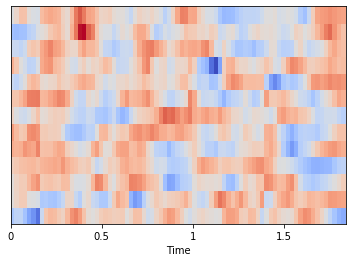

1/1440 MFCC created: RAVDESS/mfcc/03-01-08-02-01-01-04-00.nparray
Shape: (13, 78)


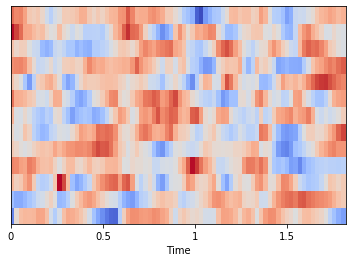

2/1440 MFCC created: RAVDESS/mfcc/03-01-08-01-01-02-08-00.nparray
Shape: (13, 92)


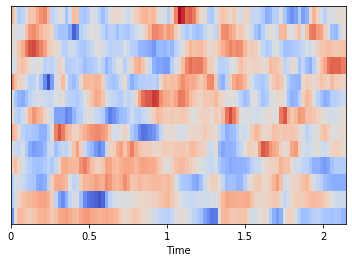

3/1440 MFCC created: RAVDESS/mfcc/03-01-02-02-02-02-21-00.nparray
Shape: (13, 138)


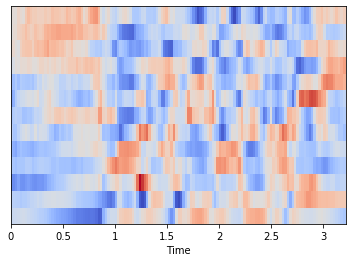

4/1440 MFCC created: RAVDESS/mfcc/03-01-02-02-01-01-03-00.nparray
Shape: (13, 88)


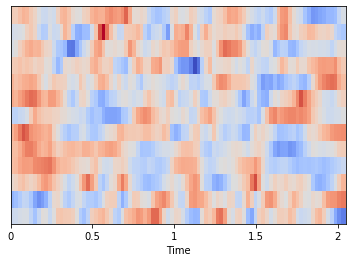

5/1440 MFCC created: RAVDESS/mfcc/03-01-06-02-01-02-20-00.nparray
6/1440 MFCC created: RAVDESS/mfcc/03-01-02-02-02-01-11-00.nparray
7/1440 MFCC created: RAVDESS/mfcc/03-01-04-01-02-02-07-00.nparray
8/1440 MFCC created: RAVDESS/mfcc/03-01-06-02-02-01-09-00.nparray
9/1440 MFCC created: RAVDESS/mfcc/03-01-04-01-02-02-18-00.nparray
10/1440 MFCC created: RAVDESS/mfcc/03-01-06-01-02-02-06-00.nparray
11/1440 MFCC created: RAVDESS/mfcc/03-01-08-02-02-02-17-00.nparray
12/1440 MFCC created: RAVDESS/mfcc/03-01-05-01-02-01-08-00.nparray
13/1440 MFCC created: RAVDESS/mfcc/03-01-04-01-02-01-13-00.nparray
14/1440 MFCC created: RAVDESS/mfcc/03-01-04-01-01-01-18-00.nparray
15/1440 MFCC created: RAVDESS/mfcc/03-01-02-02-02-01-04-00.nparray
16/1440 MFCC created: RAVDESS/mfcc/03-01-03-01-01-02-02-00.nparray
17/1440 MFCC created: RAVDESS/mfcc/03-01-08-01-01-02-05-00.nparray
18/1440 MFCC created: RAVDESS/mfcc/03-01-07-01-01-01-22-00.nparray
19/1440 MFCC created: RAVDESS/mfcc/03-01-05-02-02-02-09-00.nparray


In [21]:
ravdess.create_mfcc(show_first_n=5)

In [23]:
# STEP 5: Create dataframe
df = ravdess.create_dataframe_mfcc()
df.head()

Create MFCC dataframe


,emotion,emotion_intensity,statement,repetition,actor,actor_gender,mfcc_path,original_data_id,enrichment_num
0,sad,strong,Kids_are_talking_by_the_door,01,14,female,RAVDESS/mfcc/03-01-04-02-01-01-14-00.nparray,03-01-04-02-01-01-14,00
1,fearful,normal,Kids_are_talking_by_the_door,01,12,female,RAVDESS/mfcc/03-01-06-01-01-01-12-00.nparray,03-01-06-01-01-01-12,00
2,angry,normal,Dogs_are_sitting_by_the_door,02,07,male,RAVDESS/mfcc/03-01-05-01-02-02-07-00.nparray,03-01-05-01-02-02-07,00
3,disgust,normal,Dogs_are_sitting_by_the_door,02,04,female,RAVDESS/mfcc/03-01-07-01-02-02-04-00.nparray,03-01-07-01-02-02-04,00
4,fearful,strong,Kids_are_talking_by_the_door,01,05,male,RAVDESS/mfcc/03-01-06-02-01-01-05-00.nparray,03-01-06-02-01-01-05,00


In [24]:
!rm -rf 'RAVDESS/train_valid/'
!mkdir 'RAVDESS/train_valid/'
!mkdir 'RAVDESS/train_valid/train/'
!mkdir 'RAVDESS/train_valid/valid/'
ravdess.create_train_structure_mfcc(df)

sad
fearful
angry
disgust
surprised
happy
calm


In [25]:
!echo "Files in RAVDESS/train_valid/train/calm" $(find RAVDESS/train_valid/train/calm -type f| wc -l)
!echo "Files in RAVDESS/train_valid/valid/calm" $(find RAVDESS/train_valid/valid/calm -type f| wc -l)
!echo "Files in RAVDESS/train_valid/train/happy:" $(find RAVDESS/train_valid/train/happy -type f| wc -l)
!echo "Files in RAVDESS/train_valid/valid/happy:" $(find RAVDESS/train_valid/valid/happy -type f| wc -l)
!echo "Files in RAVDESS/train_valid/train/angry:" $(find RAVDESS/train_valid/train/angry -type f| wc -l)
!echo "Files in RAVDESS/train_valid/valid/angry:" $(find RAVDESS/train_valid/valid/angry -type f| wc -l)
!echo "Files in RAVDESS/train_valid/train/fearful" $(find RAVDESS/train_valid/train/fearful -type f| wc -l)
!echo "Files in RAVDESS/train_valid/valid/fearful" $(find RAVDESS/train_valid/valid/fearful -type f| wc -l)
!echo "Files in RAVDESS/train_valid/train/sad" $(find RAVDESS/train_valid/train/sad -type f| wc -l)
!echo "Files in RAVDESS/train_valid/valid/sad" $(find RAVDESS/train_valid/valid/sad -type f| wc -l)

Files in RAVDESS/train_valid/train/calm 67
Files in RAVDESS/train_valid/valid/calm 29
Files in RAVDESS/train_valid/train/happy: 67
Files in RAVDESS/train_valid/valid/happy: 29
Files in RAVDESS/train_valid/train/angry: 67
Files in RAVDESS/train_valid/valid/angry: 29
Files in RAVDESS/train_valid/train/fearful 67
Files in RAVDESS/train_valid/valid/fearful 29
Files in RAVDESS/train_valid/train/sad 67
Files in RAVDESS/train_valid/valid/sad 29
find: ‘RAVDESS/train_valid/train/neutral’: No such file or directory
Files in RAVDESS/train_valid/train/neutral 0
find: ‘RAVDESS/train_valid/valid/neutral’: No such file or directory
Files in RAVDESS/train_valid/valid/neutral 0


In [26]:
!ls  RAVDESS/train_valid/train/angry | head
!ls  RAVDESS/train_valid/valid/angry | head

03-01-05-02-01-01-01-00.nparray
03-01-05-02-01-01-02-00.nparray
03-01-05-02-01-01-03-00.nparray
03-01-05-02-01-01-05-00.nparray
03-01-05-02-01-01-08-00.nparray
03-01-05-02-01-01-11-00.nparray
03-01-05-02-01-01-13-00.nparray
03-01-05-02-01-01-14-00.nparray
03-01-05-02-01-01-16-00.nparray
03-01-05-02-01-01-18-00.nparray
03-01-05-02-01-01-04-00.nparray
03-01-05-02-01-01-06-00.nparray
03-01-05-02-01-01-07-00.nparray
03-01-05-02-01-01-09-00.nparray
03-01-05-02-01-01-10-00.nparray
03-01-05-02-01-01-12-00.nparray
03-01-05-02-01-01-15-00.nparray
03-01-05-02-01-01-17-00.nparray
03-01-05-02-01-01-21-00.nparray
03-01-05-02-01-01-22-00.nparray


# Export to Google Drive

This part is optional. It is used to export the modified Data Set to your Google Drive.

In [27]:
!zip -r RAVDESS_mfcc_strong.zip RAVDESS/train_valid

  adding: RAVDESS/train_valid/ (stored 0%)
  adding: RAVDESS/train_valid/valid/ (stored 0%)
  adding: RAVDESS/train_valid/valid/fearful/ (stored 0%)
  adding: RAVDESS/train_valid/valid/fearful/03-01-06-02-02-02-16-00.nparray (deflated 54%)
  adding: RAVDESS/train_valid/valid/fearful/03-01-06-02-02-01-01-00.nparray (deflated 54%)
  adding: RAVDESS/train_valid/valid/fearful/03-01-06-02-02-01-21-00.nparray (deflated 54%)
  adding: RAVDESS/train_valid/valid/fearful/03-01-06-02-01-01-17-00.nparray (deflated 55%)
  adding: RAVDESS/train_valid/valid/fearful/03-01-06-02-01-01-22-00.nparray (deflated 54%)
  adding: RAVDESS/train_valid/valid/fearful/03-01-06-02-02-01-17-00.nparray (deflated 54%)
  adding: RAVDESS/train_valid/valid/fearful/03-01-06-02-02-02-11-00.nparray (deflated 54%)
  adding: RAVDESS/train_valid/valid/fearful/03-01-06-02-02-01-02-00.nparray (deflated 54%)
  adding: RAVDESS/train_valid/valid/fearful/03-01-06-02-02-01-16-00.nparray (deflated 54%)
  adding: RAVDESS/train_valid/va

In [28]:
!ls -lh

total 436M
drwxr-xr-x 9 root root 4.0K Dec 13 22:54 RAVDESS
-rw-r--r-- 1 root root 8.6M Dec 13 22:54 RAVDESS_mfcc_strong.zip
-rw-r--r-- 1 root root 427M Dec 13 22:51 RAVDESS.zip
drwxr-xr-x 1 root root 4.0K Dec 12 16:48 sample_data


In [0]:
# Export the data to your drive

!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials

# zip name must match the name given to zip
zip_name = 'RAVDESS_mfcc_strong.zip'

# Authenticate and create the PyDrive client.
# This only needs to be done once in a notebook.
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)

# Create & upload a file.
uploaded = drive.CreateFile({'title': zip_name})
uploaded.SetContentFile(zip_name)
uploaded.Upload()
print('Uploaded file with ID {}'.format(uploaded.get('id')))